Python 代码实现
下面是一个简单的 Python 代码示例，展示如何使用节点法构建复杂管网的数学模型，并进行求解。我们将使用 scipy 库来进行数值求解。

Node J-1: Head = 159.88 m
Node J-2: Head = 159.89 m
Node R-1: Head = 149.96 m
Pipe P-1: Flow = 99.89 L/s
Pipe P-2: Flow = 249.89 L/s
Pump PU-1: Flow = 714938096261655691264.00 L/s


C:\Users\Administrator\AppData\Local\Temp\ipykernel_16292\694279885.py:99: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  solution = fsolve(system_equations, initial_variables)


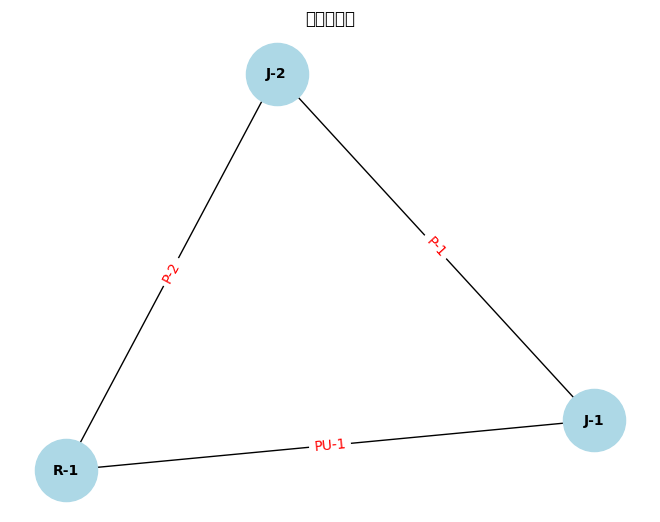

In [7]:
import numpy as np
from scipy.optimize import fsolve
import networkx as nx
import matplotlib.pyplot as plt

# 定义常数
g = 9.81  # 重力加速度 (m/s^2)

# 定义管网参数
nodes = ['J-1', 'J-2', 'R-1']
pipes = {
    'P-1': {'start': 'J-1', 'end': 'J-2', 'length': 1000, 'diameter': 0.3048, 'roughness': 100},
    'P-2': {'start': 'J-2', 'end': 'R-1', 'length': 1000, 'diameter': 0.3048, 'roughness': 100},
    'PU-1': {'start': 'R-1', 'end': 'J-1', 'head': 60.0}  # 泵提供的扬程
}

# 假设的需求
demands = {'J-1': 100 / 3600, 'J-2': 150 / 3600}  # 需求单位转换为 m³/s

# 假设的水库水头
reservoir_head = {'R-1': 150.0}

# 定义节点数
num_nodes = len(nodes)

# 初始化节点水头
initial_heads = np.ones(num_nodes) * 100.0

# 定义节点索引
node_indices = {node: i for i, node in enumerate(nodes)}

# 定义管道索引
pipe_indices = {pipe_id: i for i, pipe_id in enumerate(pipes.keys())}

# 计算摩阻系数 f
def colebrook_white(Re, k, D):
    f = 0.01
    for _ in range(10):  # 迭代 10 次
        if Re == 0:
            break  # 如果雷诺数为零，跳出循环
        term1 = k / (3.7 * D)
        term2 = 2.51 / (Re * np.sqrt(f))
        if term2 == 0:
            break  # 如果 term2 为零，跳出循环
        f_new = (-2 * np.log10(term1 + term2)) ** -2
        if abs(f - f_new) < 1e-6:
            break
        f = f_new
    return f

# 达西-魏斯巴赫公式
def darcy_weisbach(Q, L, D, f):
    v = Q / (np.pi * (D / 2) ** 2)
    hf = f * (L / D) * (v ** 2) / (2 * g)
    return hf

# 定义系统方程
def system_equations(variables):
    heads = variables[:num_nodes]
    flows = variables[num_nodes:]
    
    equations = []
    
    for node in nodes:
        if node in reservoir_head:
            equations.append(heads[node_indices[node]] - reservoir_head[node])
        else:
            flow_balance = 0
            for pipe_id, pipe in pipes.items():
                if pipe['start'] == node:
                    head_diff = heads[node_indices[pipe['start']]] - heads[node_indices[pipe['end']]]
                    if 'length' in pipe:  # 管道
                        Re = (flows[pipe_indices[pipe_id]] * 4 * pipe['diameter']) / (np.pi * 1e-6)  # 动力粘度 1e-6 m²/s
                        f = colebrook_white(Re, pipe['roughness'], pipe['diameter'])
                        hf = darcy_weisbach(flows[pipe_indices[pipe_id]], pipe['length'], pipe['diameter'], f)
                        flow_balance += flows[pipe_indices[pipe_id]]
                        equations.append(head_diff - hf)
                    elif 'head' in pipe:  # 泵
                        pump_index = pipe_indices[pipe_id]
                        equations.append(heads[node_indices[pipe['start']]] - heads[node_indices[pipe['end']]] - pipe['head'])
                elif pipe['end'] == node:
                    head_diff = heads[node_indices[pipe['end']]] - heads[node_indices[pipe['start']]]
                    if 'length' in pipe:  # 管道
                        Re = (flows[pipe_indices[pipe_id]] * 4 * pipe['diameter']) / (np.pi * 1e-6)  # 动力粘度 1e-6 m²/s
                        f = colebrook_white(Re, pipe['roughness'], pipe['diameter'])
                        hf = darcy_weisbach(flows[pipe_indices[pipe_id]], pipe['length'], pipe['diameter'], f)
                        flow_balance -= flows[pipe_indices[pipe_id]]
                        equations.append(head_diff - hf)
            if node in demands:
                flow_balance -= demands[node]
            equations.append(flow_balance)
    
    return equations

# 初始变量
initial_variables = np.concatenate([initial_heads, np.zeros(len(pipes))])

# 求解系统方程
solution = fsolve(system_equations, initial_variables)

# 分离结果
heads_solution = solution[:num_nodes]
flows_solution = solution[num_nodes:]

# 打印结果
for node, index in node_indices.items():
    print(f"Node {node}: Head = {heads_solution[index]:.2f} m")

for pipe_id, index in pipe_indices.items():
    if 'length' in pipes[pipe_id]:  # 管道
        print(f"Pipe {pipe_id}: Flow = {flows_solution[index] * 3600:.2f} L/s")
    elif 'head' in pipes[pipe_id]:  # 泵
        print(f"Pump {pipe_id}: Flow = {flows_solution[index] * 3600:.2f} L/s")

# 使用 NetworkX 绘制管网拓扑
G = nx.Graph()
for node in nodes:
    G.add_node(node)
for pipe_id, pipe in pipes.items():
    G.add_edge(pipe['start'], pipe['end'], label=pipe_id)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title('管网拓扑图')
plt.show()